In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import matplotlib
import warnings
import pypoman
import plotly.offline as py
import plotly.graph_objs as go
import time

import quantpy as qp

from cycler import cycler

titlesize = 32
labelsize = 44
legendsize = 32
xticksize = 34
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 30
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)
matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

warnings.filterwarnings('ignore', category=np.ComplexWarning)

%matplotlib inline

In [6]:
%run Imports.ipynb
from quantpy.tomography.interval import ConfidenceInterval, _pop_hidden_keys, Mode

import numpy as np
import scipy.linalg as la
import scipy.stats as sts
import polytope as pc
import math
import pypoman

from enum import Enum, auto
from abc import ABC, abstractmethod
from scipy.interpolate import interp1d
from collections import Counter, defaultdict
from functools import partial
from cvxopt import matrix, solvers

from quantpy.geometry import hs_dst, trace_dst, if_dst
from quantpy.polytope import compute_polytope_volume, find_max_distance_to_polytope
from quantpy.qobj import Qobj
from quantpy.routines import (
    _left_inv, _vec2mat, _mat2vec,
    _matrix_to_real_tril_vec, _real_tril_vec_to_matrix,
)

In [7]:
results = {'Ry13_Id': {'__0__': 3520, '__1__': 4672},
           'Ry13_Rx': {'__0__': 4033, '__1__': 4159},
           'Ry13_Ry': {'__0__': 1589, '__1__': 6603},
           'RyRz23_Id': {'__0__': 3593, '__1__': 4599},
           'RyRz23_Rx': {'__0__': 6834, '__1__': 1358},
           'RyRz23_Ry': {'__0__': 5488, '__1__': 2704},
           'RyRz43_Id': {'__0__': 3515, '__1__': 4677},
           'RyRz43_Rx': {'__0__': 2403, '__1__': 5789},
           'RyRz43_Ry': {'__0__': 6167, '__1__': 2025},
           'nothing_Id': {'__0__': 7473, '__1__': 719},
           'nothing_Rx': {'__0__': 4373, '__1__': 3819},
           'nothing_Ry': {'__0__': 4288, '__1__': 3904}}

In [8]:
POVM_base = np.array([
    [0.972, 0],
    [0, 0.093],
])

POVM_3 = [POVM_base, np.eye(2) - POVM_base]
POVM_2 = [qp.operator.RX(np.pi / 2).H.as_channel().transform(elem) for elem in POVM_3]
POVM_1 = [qp.operator.RY(np.pi / 2).H.as_channel().transform(elem) for elem in POVM_3]

POVM_3_matrix = np.array([qp.Qobj(elem).bloch for elem in POVM_3])
POVM_2_matrix = np.array([qp.Qobj(elem).bloch for elem in POVM_2])
POVM_1_matrix = np.array([qp.Qobj(elem).bloch for elem in POVM_1])

POVM_matrix = np.stack([POVM_1_matrix, POVM_2_matrix, POVM_3_matrix], axis=0)

In [9]:
ry = qp.operator.RY(np.arccos(-1 / 3)).as_channel()
rz23 = qp.operator.RZ(np.pi * 2 / 3).as_channel()
rz43 = qp.operator.RZ(np.pi * 4 / 3).as_channel()

state_1 = qp.Qobj([1, 0], True)
state_2 = ry.transform(state_1)
state_3 = rz23.transform(state_2)
state_4 = rz43.transform(state_2)

input_basis = [state_1, state_2, state_3, state_4]

### State tomography

In [71]:
class WangIntervalFidelity(ConfidenceInterval):    
    def __init__(self, tmg, n_points=1000, target_state=None):
        kwargs = _pop_hidden_keys(locals())
        super().__init__(tmg, **kwargs)
        
    def __call__(self, conf_levels=None):
        if conf_levels is None:
            conf_levels = np.linspace(1e-3, 1-1e-3, 1000)
        if not hasattr(self, 'cl_to_dist_max'):
            self.setup()
        return (self.cl_to_dist_min(conf_levels), self.cl_to_dist_max(conf_levels)), conf_levels

    def setup(self):
        if self.mode == Mode.CHANNEL:
            raise NotImplementedError("This interval works only for state tomography")
            
        if self.target_state is None:
            self.target_state = self.tmg.state
        
        dim = 2 ** self.tmg.state.n_qubits
        frequencies = np.clip(self.tmg.raw_results / self.tmg.n_measurements[:, None], self.EPS, 1 - self.EPS)

        povm_matrix = (np.reshape(self.tmg.povm_matrix * self.tmg.n_measurements[:, None, None]
                                  / np.sum(self.tmg.n_measurements),
                                  (-1, self.tmg.povm_matrix.shape[-1]))
                       * self.tmg.povm_matrix.shape[0])
        A = np.ascontiguousarray(povm_matrix[:, 1:]) * dim
        
        max_delta = count_delta(1-1e-5, frequencies, self.tmg.n_measurements)
        min_delta = count_delta(0, frequencies, self.tmg.n_measurements)
        deltas = np.linspace(min_delta, max_delta, self.n_points)
        
        dist_max = []
        dist_min = []
        for delta in deltas:
            b = np.clip(np.hstack(frequencies) + delta, self.EPS, 1 - self.EPS) - povm_matrix[:, 0]
            c = matrix(self.target_state.bloch[1:])
            G, h = matrix(A), matrix(b)
            sol = solvers.lp(c, G, h)
            if not sol['primal objective']:
                dist_min.append(1)
            else:
                dist_min.append(1/dim + sol['primal objective'] * dim)
            sol = solvers.lp(-c, G, h)
            if not sol['primal objective']:
                dist_max.append(1)
            else:
                dist_max.append(1/dim - sol['primal objective'] * dim)
        
        conf_levels = []
        for delta in deltas:
            conf_levels.append(count_confidence(delta, frequencies, self.tmg.n_measurements))
        self.cl_to_dist_max = interp1d(conf_levels, dist_max)
        self.cl_to_dist_min = interp1d(conf_levels, dist_min)
    
    
def count_confidence(delta, frequencies, n_measurements):
    EPS = 1e-15
    freq_plus_delta = np.clip(frequencies + delta, EPS, 1 - EPS)
    KL_divergence = (frequencies * np.log(frequencies / freq_plus_delta)
                     + (1 - frequencies) * np.log(
                (1 - frequencies) / (1 - freq_plus_delta)))
    KL_divergence = np.where(freq_plus_delta < 1 - EPS, KL_divergence, np.inf)
    epsilons = np.exp(-n_measurements[:, None] * KL_divergence)
    epsilons = np.where(np.abs(frequencies - 1) < 2 * EPS, 0, epsilons)
    return np.prod(np.maximum(1 - np.sum(epsilons, axis=-1), 0))


def count_delta(target_cl, frequencies, n_measurements):
    EPS = 1e-10
    left = 1e-10
    right = 1
    while right - left > 1e-10:
        delta = (left + right) / 2
        confidence = count_confidence(delta, frequencies, n_measurements)
        if confidence < target_cl + EPS:
            left = delta
        else:
            right = delta
    return delta


class ProcessWangIntervalFidelity(ConfidenceInterval):
    def __init__(self, tmg, n_points=1000, target_channel=None):
        kwargs = _pop_hidden_keys(locals())
        super().__init__(tmg, **kwargs)
        
    def __call__(self, conf_levels=None):
        if conf_levels is None:
            conf_levels = np.linspace(1e-3, 1-1e-3, 1000)
        if not hasattr(self, 'cl_to_dist_max'):
            self.setup()
        return (self.cl_to_dist_min(conf_levels), self.cl_to_dist_max(conf_levels)), conf_levels
        
    def setup(self):
        channel = self.tmg.channel
        dim = 4 ** channel.n_qubits
        bloch_dim = dim ** 2 - dim
        
        if self.target_channel is None:
            self.target_channel = channel
        
        povm_matrix = self.tmg.tomographs[0].povm_matrix
        n_measurements = self.tmg.tomographs[0].n_measurements

        frequencies = np.asarray([
            np.clip(tmg.raw_results / tmg.n_measurements[:, None], self.EPS, 1 - self.EPS)
            for tmg in self.tmg.tomographs
        ])
        
        eta_matrix = (np.reshape(povm_matrix * n_measurements[:, None, None] / np.sum(n_measurements),
                                  (-1, povm_matrix.shape[-1])) 
                       * povm_matrix.shape[0])
        Rt = np.asarray([rho.T.bloch for rho in self.tmg.input_basis.elements])
        pi_matrix = np.einsum("ij,ab->iajb", Rt, eta_matrix)
        pi_matrix = pi_matrix.reshape((pi_matrix.shape[0] * pi_matrix.shape[1],
                                       pi_matrix.shape[2] * pi_matrix.shape[3]))
        A = np.ascontiguousarray(pi_matrix[:, dim:]) * dim
        
        max_delta = count_delta(1-1e-5, frequencies, n_measurements)
        min_delta = count_delta(0, frequencies, n_measurements)
        deltas = np.linspace(min_delta, max_delta, self.n_points)
        
        dist_max = []
        dist_min = []
        for delta in deltas:
            b = (np.clip(np.hstack(np.concatenate(frequencies, axis=0)) + delta, self.EPS, 1 - self.EPS) 
                 - pi_matrix[:, 0] * 2 ** channel.n_qubits)
            c = matrix(self.target_channel.choi.bloch[dim:])
            G, h = matrix(A), matrix(b)
            sol = solvers.lp(c, G, h)
            if not sol['primal objective']:
                dist_min.append(1)
            else:
                dist_min.append(1/dim + sol['primal objective'])
            sol = solvers.lp(-c, G, h)
            if not sol['primal objective']:
                dist_max.append(1)
            else:
                dist_max.append(1/dim - sol['primal objective'])

        conf_levels = []
        for delta in deltas:
            conf_levels.append(count_confidence(delta, frequencies, self.tmg.tomographs[0].n_measurements))
        self.cl_to_dist_max = interp1d(conf_levels, dist_max)
        self.cl_to_dist_min = interp1d(conf_levels, dist_min)

In [40]:
class PolytopeTomograph(qp.StateTomograph):
    def polytope_interval(self, n_points):        
        EPS = 1e-15
        rho = self.point_estimate('lin')
        dim = 2 ** self.state.n_qubits

        frequencies = np.clip(self.raw_results / self.n_measurements[:, None], EPS, 1 - EPS)

        POVM_matrix = np.reshape(
            self.POVM_matrix * self.n_measurements[:, None, None] / np.sum(self.n_measurements),
            (-1, self.POVM_matrix.shape[-1])) * dim * self.POVM_matrix.shape[0]
        deltas = np.linspace(0, 1, n_points)
        dist = []
        for delta in tqdm(deltas):
            A = POVM_matrix[:, 1:]
            b = np.clip(np.hstack(frequencies) + delta, EPS, 1 - EPS) - POVM_matrix[:, 0] / dim
            vertices = pypoman.compute_polytope_vertices(A, b)
            vertex_states = [qp.tomography.state._make_feasible(qp.Qobj(np.hstack(([1 / dim], vertex)))) 
                             for vertex in vertices]
            if vertices:
                max_dist = max([self.dst(vertex_state, rho) for vertex_state in
                                vertex_states])
            else:
                max_dist = 0
            dist.append(max_dist)

        CLs = []
        for delta in tqdm(deltas):
            freq_plus_delta = np.clip(frequencies + delta, EPS, 1 - EPS)
            KL_divergence = (frequencies * np.log(frequencies / freq_plus_delta)
                             + (1 - frequencies) * np.log(
                        (1 - frequencies) / (1 - freq_plus_delta)))
            KL_divergence = np.where(freq_plus_delta < 1 - EPS, KL_divergence, np.inf)
            epsilons = np.exp(-self.n_measurements[:, None] * KL_divergence)
            epsilons = np.where(np.abs(frequencies - 1) < 2 * EPS, 0, epsilons)

            CLs.append(1 - np.sum(epsilons))
        return np.asarray(dist), np.asarray(CLs)
    
    def polytope_interval_target(self, target_state, n_points=1000):
        EPS = 1e-15
        rho = self.point_estimate('lin')
        dim = 2 ** self.state.n_qubits
        
        target_probas = np.einsum('ijk,k->ij', self.POVM_matrix, target_state.bloch) * dim
        frequencies = np.clip(self.raw_results / self.n_measurements[:, None], EPS, 1 - EPS)
        
        deltas = target_probas - frequencies
        deltas = (deltas > 0) * deltas * 2 + (deltas <= 0) * 1e-5
        deltas_add = np.linspace(0, 0.1, n_points)

        POVM_matrix = np.reshape(
            self.POVM_matrix * self.n_measurements[:, None, None] / np.sum(self.n_measurements),
            (-1, self.POVM_matrix.shape[-1])) * dim * self.POVM_matrix.shape[0]
        
        dist = []
        A = POVM_matrix[:, 1:]
        
        for delta_add in deltas_add:
            b = np.clip(np.hstack(frequencies + deltas + delta_add), EPS, 1 - EPS) - POVM_matrix[:, 0] / dim
            vertices = pypoman.compute_polytope_vertices(A, b)
            vertex_states = [qp.tomography.state._make_feasible(qp.Qobj(np.hstack(([1 / dim], vertex))))
                             for vertex in vertices]
            if vertices:
                max_dist = max([self.dst(vertex_state, target_state) for vertex_state in
                                vertex_states])
            else:
                max_dist = self.dst(rho, target_state)
            dist.append(max_dist)
        
        CLs = []
        
        for delta_add in deltas_add:
            freq_plus_delta = np.clip(frequencies + deltas + delta_add, EPS, 1 - EPS)
            KL_divergence = (frequencies * np.log(frequencies / freq_plus_delta)
                             + (1 - frequencies) * np.log(
                        (1 - frequencies) / (1 - freq_plus_delta)))
            KL_divergence = np.where(freq_plus_delta < 1 - EPS, KL_divergence, np.inf)
            epsilons = np.exp(-self.n_measurements[:, None] * KL_divergence)
            epsilons = np.where(np.abs(frequencies - 1) < 2 * EPS, 0, epsilons)
            CLs.append(1 - np.sum(epsilons))
        
        return np.asarray(dist), np.asarray(CLs)
    
    def make_polytope(self, target_state):
        EPS = 1e-15
        rho = self.point_estimate('lin')
        dim = 2 ** self.state.n_qubits
        
        target_probas = np.einsum('ijk,k->ij', self.POVM_matrix, target_state.bloch) * dim
        frequencies = np.clip(self.raw_results / self.n_measurements[:, None], EPS, 1 - EPS)
        deltas = target_probas - frequencies
        print("Deltas:\n", deltas, sep="")
        deltas = (deltas > 0) * deltas + (deltas <= 0) * 1e-5
        print("Deltas:\n", deltas, sep="")

        POVM_matrix = np.reshape(
            self.POVM_matrix * self.n_measurements[:, None, None] / np.sum(self.n_measurements),
            (-1, self.POVM_matrix.shape[-1])) * dim * self.POVM_matrix.shape[0]
        
        A = POVM_matrix[:, 1:]
        b = np.clip(np.hstack(frequencies + deltas), EPS, 1 - EPS) - POVM_matrix[:, 0] / dim
        vertices = pypoman.compute_polytope_vertices(A, b)
        vertex_states = [qp.tomography.state._make_feasible(qp.Qobj(np.hstack(([1 / dim], vertex))))
                         for vertex in vertices]
        if vertices:
            max_dist = max([self.dst(vertex_state, target_state) for vertex_state in
                            vertex_states])
        else:
            max_dist = 0
        
        freq_plus_delta = np.clip(frequencies + deltas, EPS, 1 - EPS)
        KL_divergence = (frequencies * np.log(frequencies / freq_plus_delta)
                         + (1 - frequencies) * np.log(
                    (1 - frequencies) / (1 - freq_plus_delta)))
        KL_divergence = np.where(freq_plus_delta < 1 - EPS, KL_divergence, np.inf)
        epsilons = np.exp(-self.n_measurements[:, None] * KL_divergence)
        epsilons = np.where(np.abs(frequencies - 1) < 2 * EPS, 0, epsilons)
        
        CL = 1 - np.sum(epsilons)
        vertices = np.asarray(vertices)
        
        return vertices, CL, frequencies, epsilons

In [72]:
target_channel = qp.operator.Id.as_channel()
tmg = qp.ProcessTomograph(target_channel, input_states=input_basis)
tmg.experiment(8192, POVM_matrix)

tmg.tomographs[0].results = np.array([4288, 3904, 4373, 3819, 7473, 719])
tmg.tomographs[1].results = np.array([1589, 6603, 4033, 4159, 3520, 4672])
tmg.tomographs[2].results = np.array([5488, 2704, 6834, 1358, 3593, 4599])
tmg.tomographs[3].results = np.array([6167, 2025, 2403, 5789, 3515, 4677])

tmg.tomographs[0].raw_results = tmg.tomographs[0].results.reshape((3, 2))
tmg.tomographs[1].raw_results = tmg.tomographs[1].results.reshape((3, 2))
tmg.tomographs[2].raw_results = tmg.tomographs[2].results.reshape((3, 2))
tmg.tomographs[3].raw_results = tmg.tomographs[3].results.reshape((3, 2))

channel_hat = tmg.point_estimate()
fidelity = np.dot(target_channel.choi.bloch, channel_hat.choi.bloch)
interval = ProcessWangIntervalFidelity(tmg, target_channel=target_channel)
conf_levels = np.linspace(0.981, 1-1e-5, 100)
(dist_min, dist_max), conf_levels = interval(conf_levels)

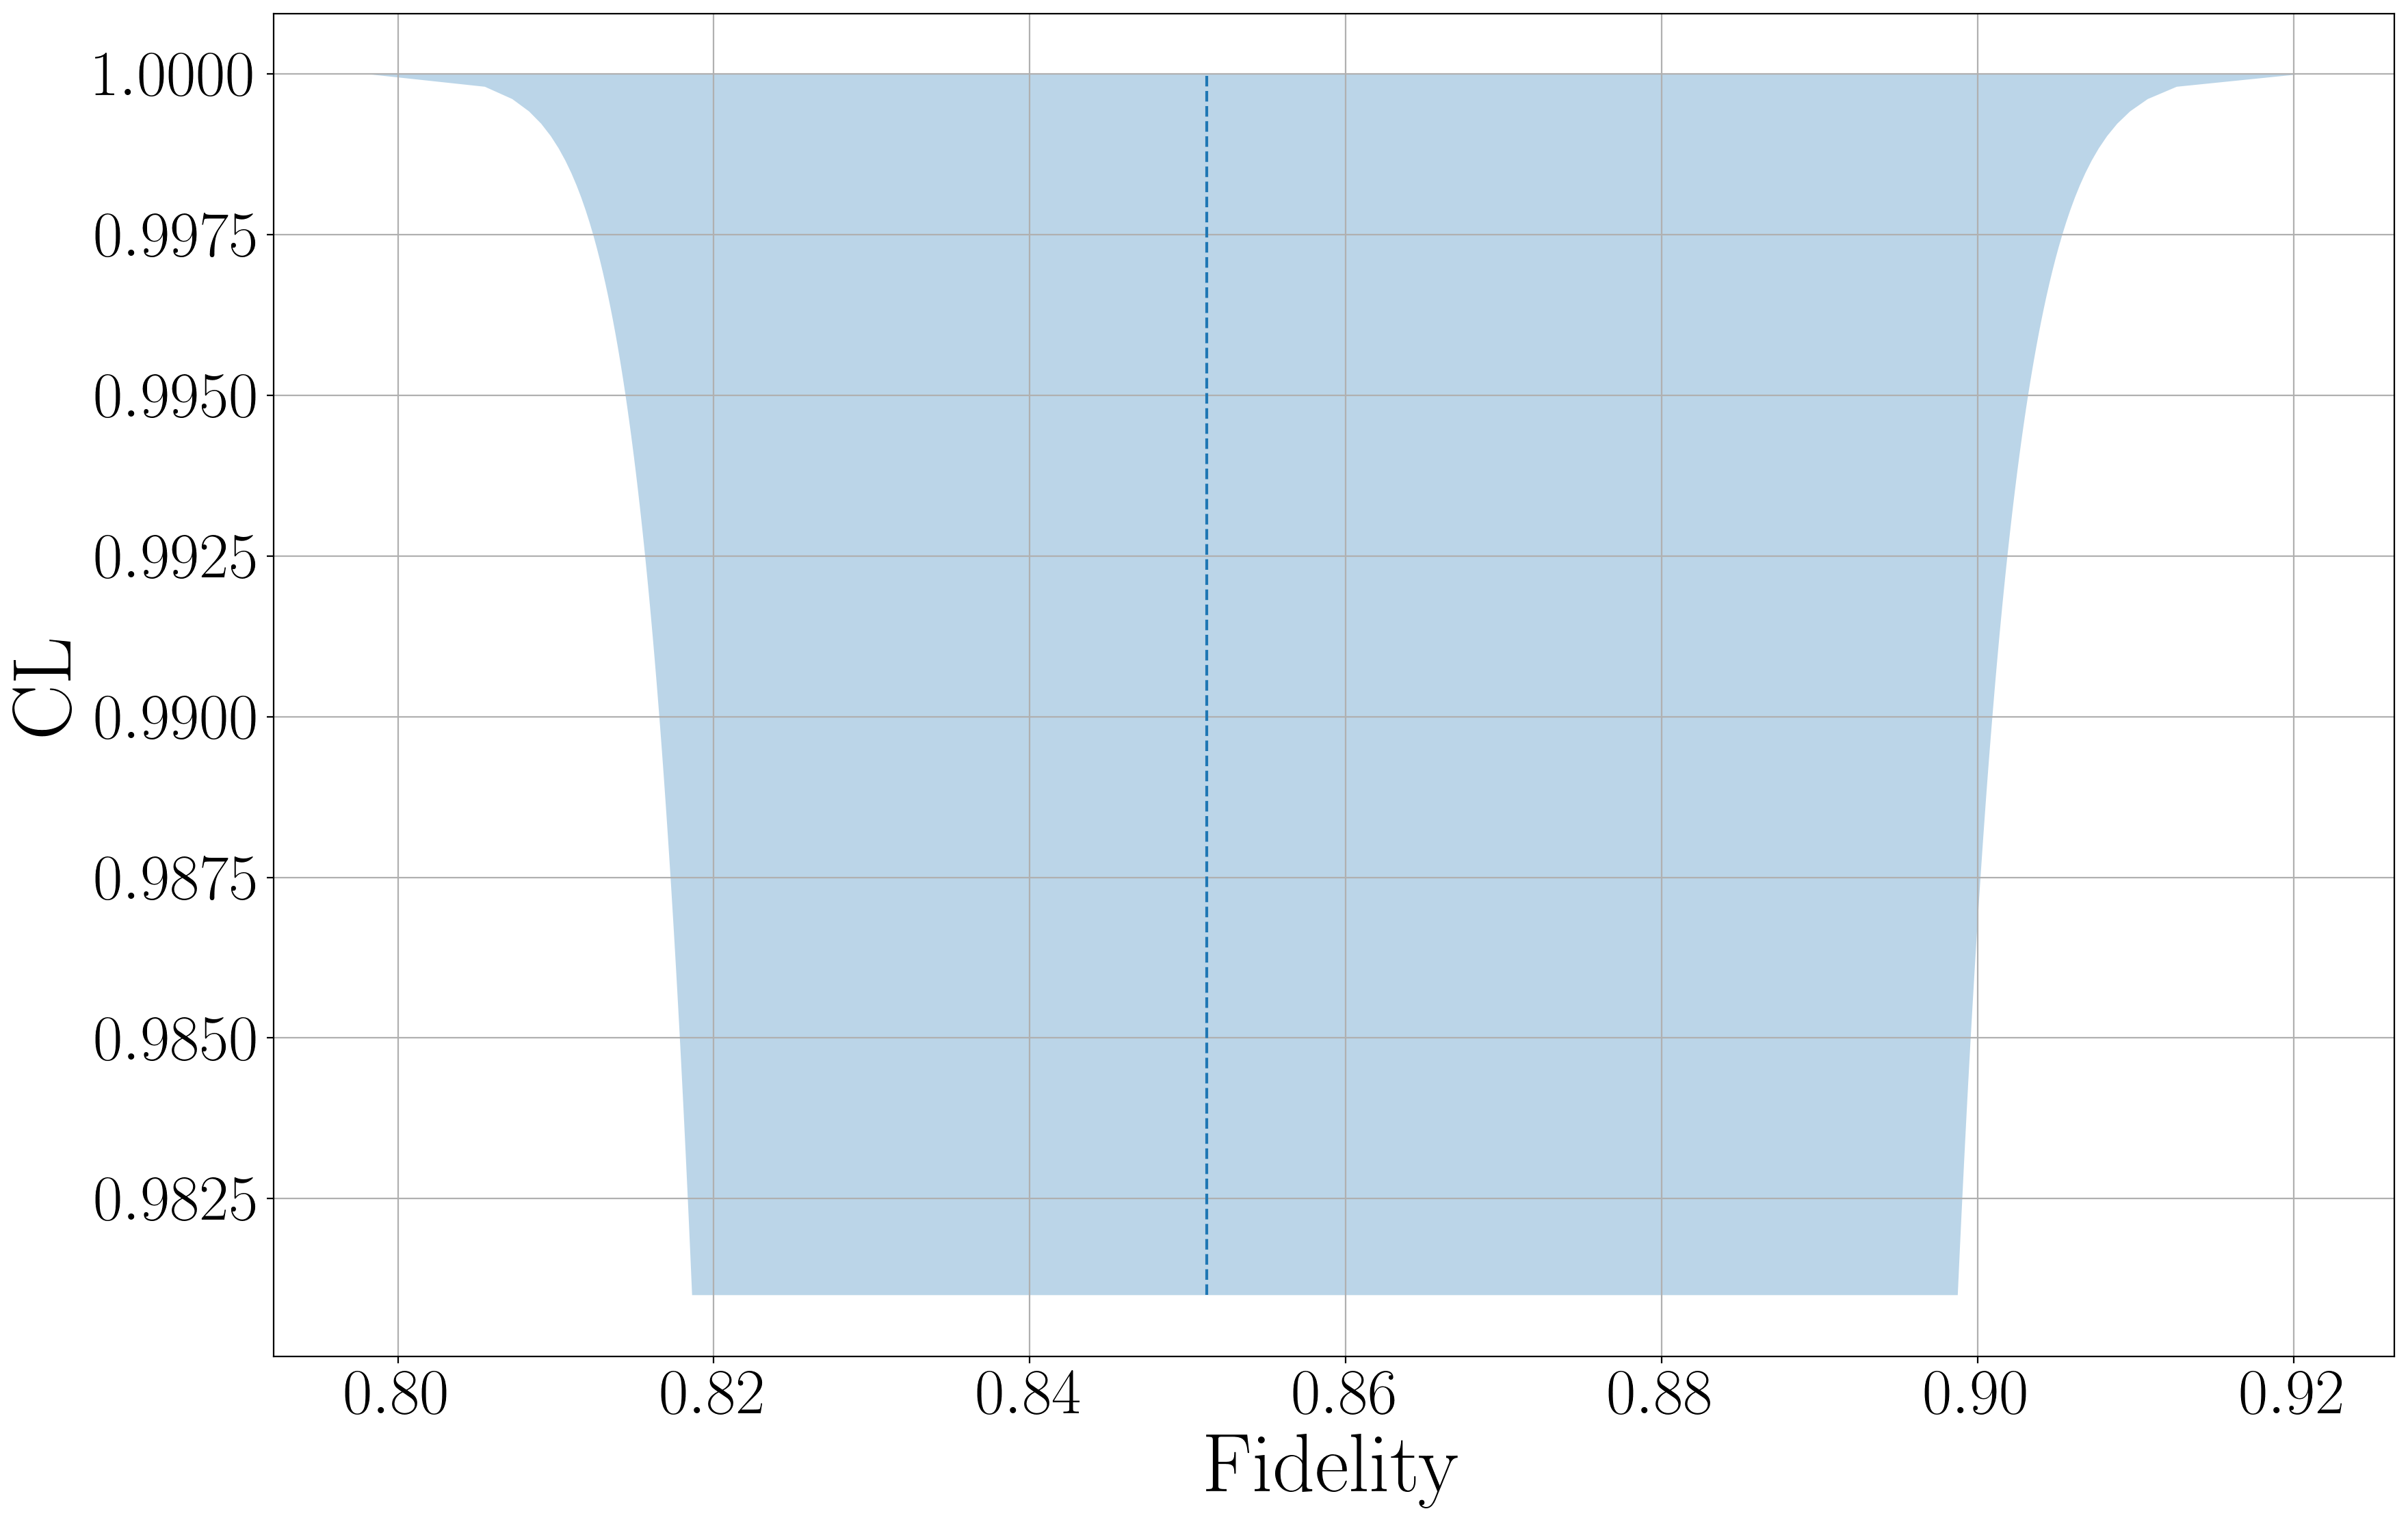

In [73]:
plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('Fidelity')
plt.ylabel('CL')
plt.grid()
plt.fill_betweenx(conf_levels, dist_min, dist_max, alpha=0.3)
plt.plot([fidelity] * 2, [conf_levels[0], conf_levels[-1]], '--')

In [41]:
tomographs = [PolytopeTomograph(state) for state in input_basis]
for tmg in tomographs:
    tmg.experiment(8192, POVM_matrix)

tomographs[0].results = np.array([4288, 3904, 4373, 3819, 7473, 719])
tomographs[1].results = np.array([1589, 6603, 4033, 4159, 3520, 4672])
tomographs[2].results = np.array([5488, 2704, 6834, 1358, 3593, 4599])
tomographs[3].results = np.array([6167, 2025, 2403, 5789, 3515, 4677])

for n in range(4):
    tomographs[n].raw_results = tomographs[n].results.reshape((3, 2))

In [42]:
n = 0

target_state = input_basis[n]
state_hat = tomographs[n].point_estimate()
dist = tomographs[n].dst(state_hat, target_state)
vertices, CL, frequencies, epsilons = tomographs[n].make_polytope(target_state)
vertex_states = [qp.tomography.state._make_feasible(qp.Qobj(np.hstack(([1 / 2], vertex))))
                 for vertex in vertices]
dist_to_vertices = np.asarray([tomographs[n].dst(target_state, vertex) for vertex in vertex_states])
print("-" * 20)
print("CL:", CL)
print("Epsilons:\n", epsilons, sep="")
print("-" * 20)
print("Distance from target state to estimated state:", dist)
print("Distance from target state to vertices:\n", dist_to_vertices, sep="")

AttributeError: 'PolytopeTomograph' object has no attribute 'POVM_matrix'

In [33]:
# japan_data = go.Data([go.Surface(x=x, y=y, z=z, opacity=0.25)])
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=vertices[:, 0], y=vertices[:, 1], z=vertices[:, 2], name='Polytope'))
fig.add_trace(go.Scatter3d(x=[target_state.bloch[1]], y=[target_state.bloch[2]], z=[target_state.bloch[3]],
                           name='Target state'))
# fig.add_trace(go.Scatter3d(x=[state.bloch[1]], y=[state.bloch[2]], z=[state.bloch[3]],
#                            name='Prepared state'))
fig.add_trace(go.Scatter3d(x=[state_hat.bloch[1]], y=[state_hat.bloch[2]], z=[state_hat.bloch[3]],
                           name='Estimated state'))
fig.update_layout(title=f"epsilons=[{epsilons[0, 0]:.4f}, {epsilons[1, 0]:.4f}, {epsilons[2, 0]:.4f}]")
fig.show()

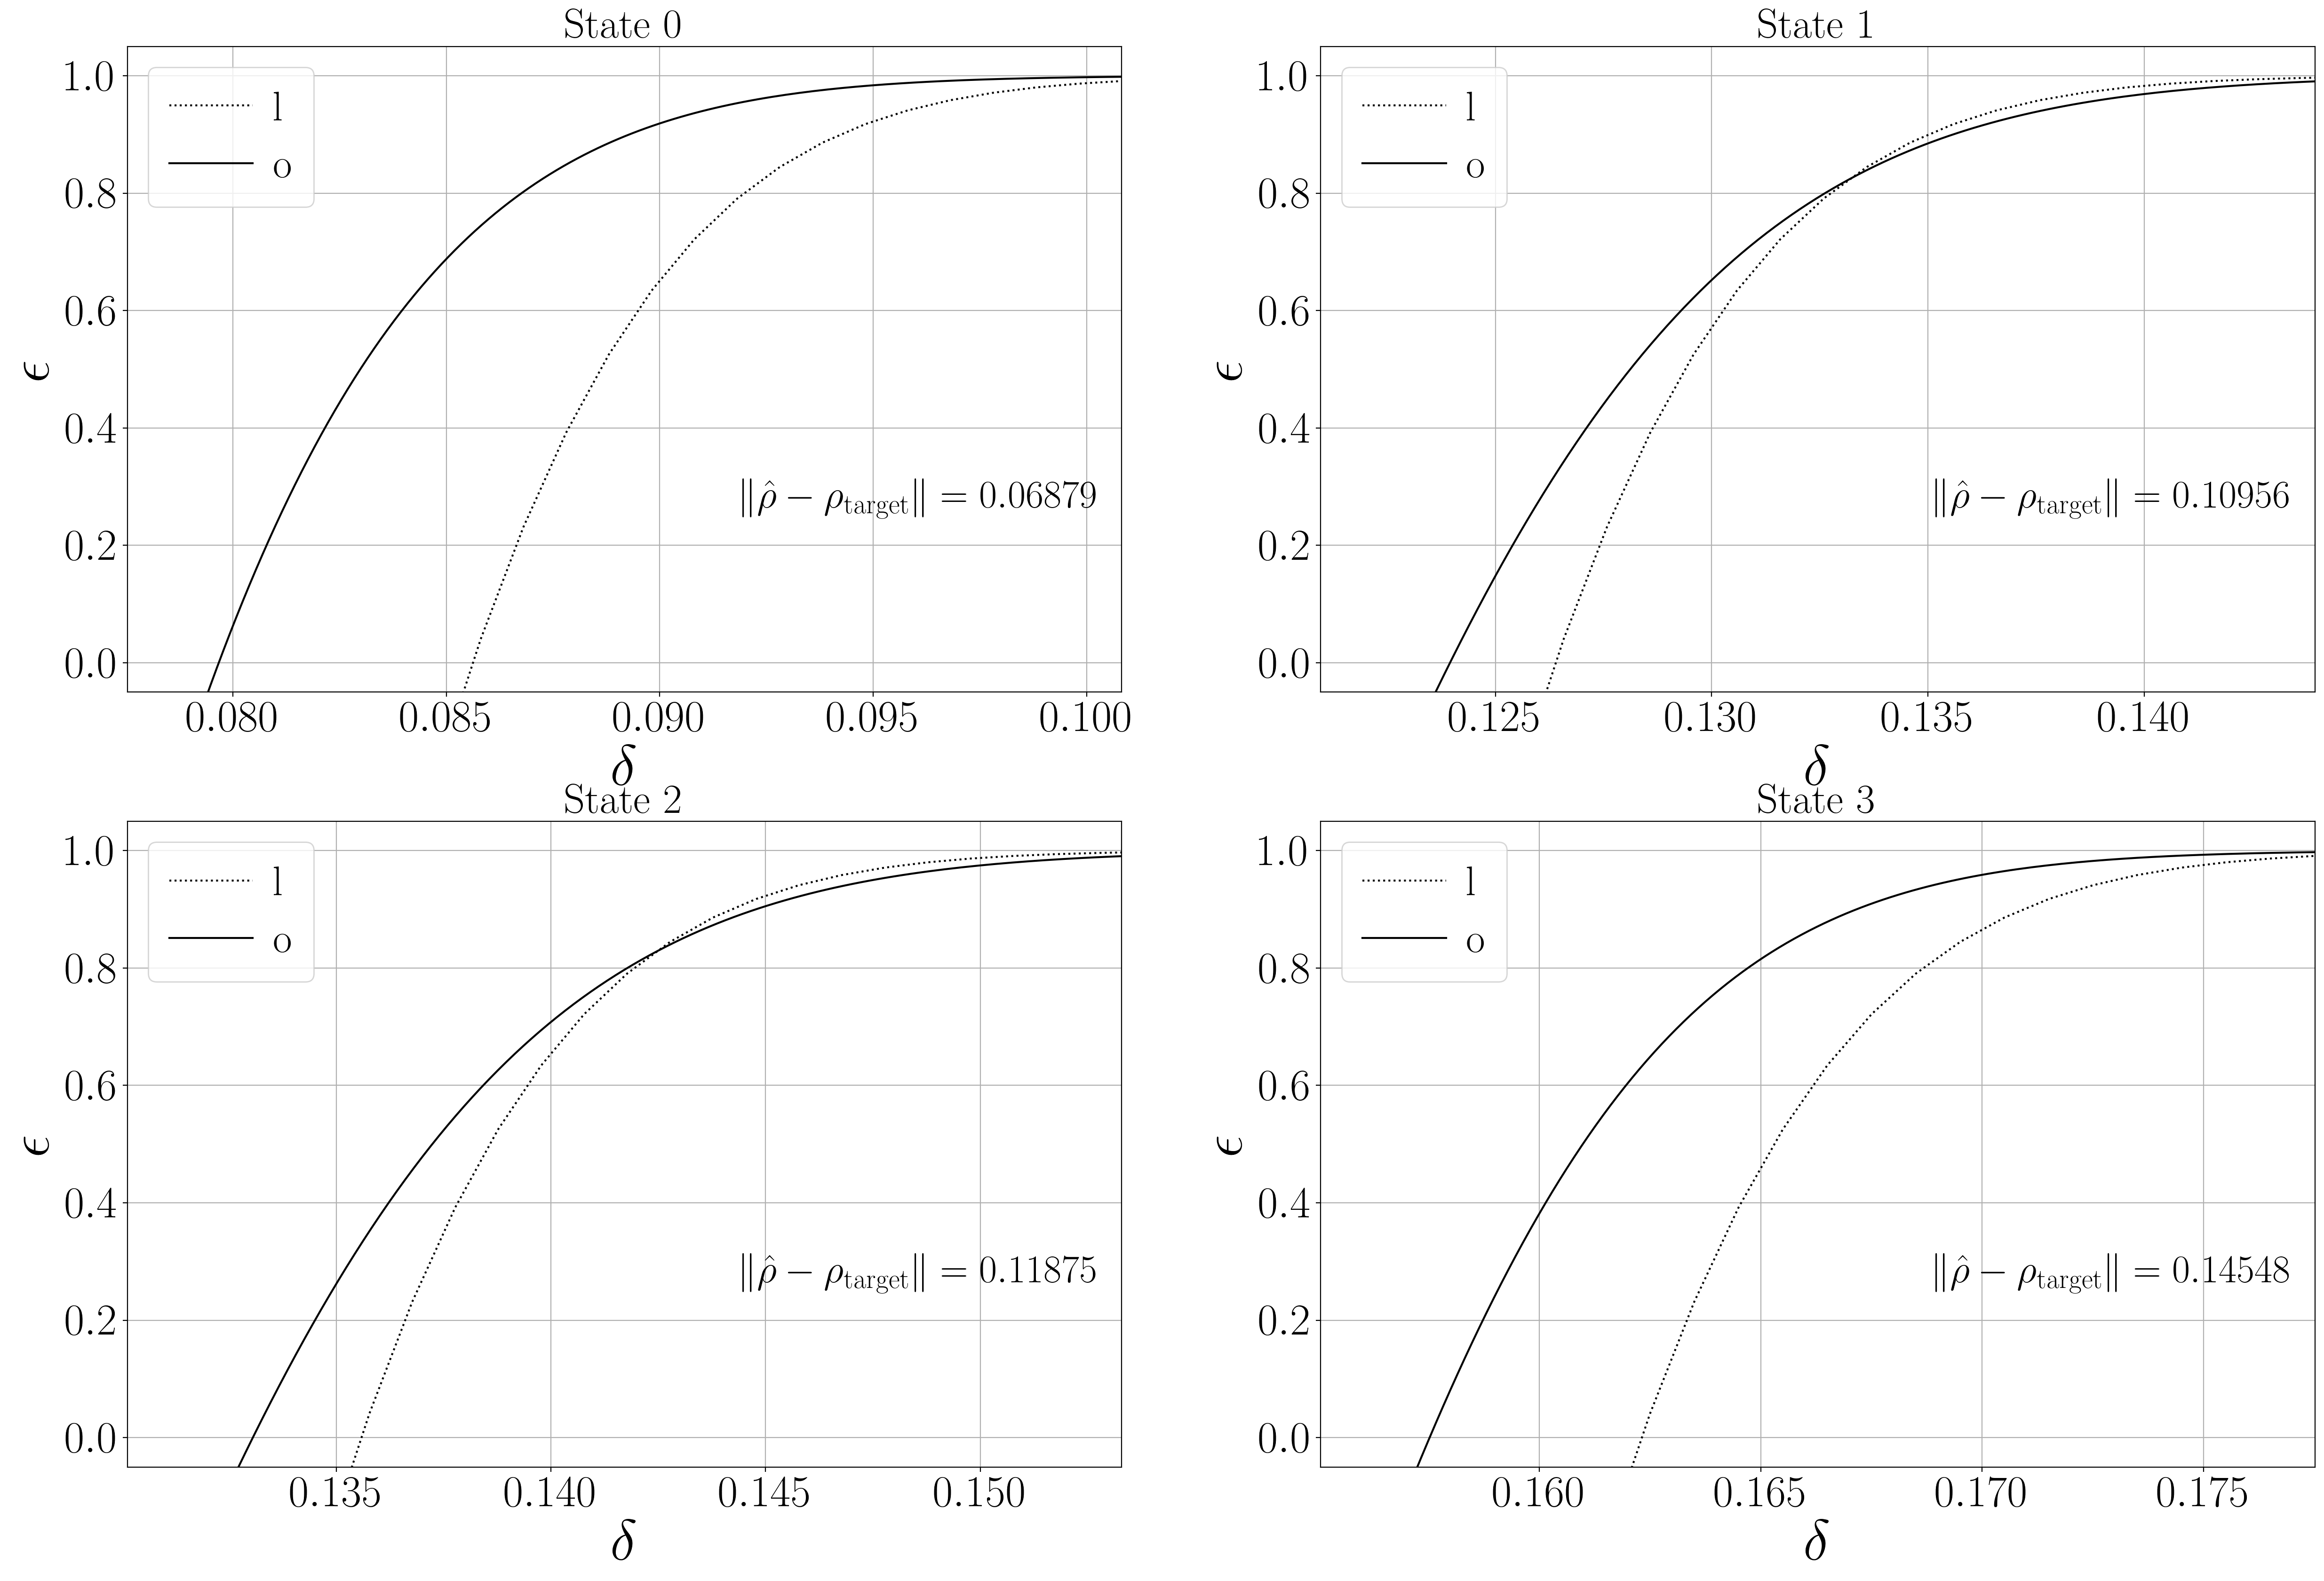

In [36]:
fig = plt.figure(figsize=(30, 20), dpi=200)

for n in range(4):
    state_hat = tomographs[n].point_estimate()
    dist_renner, CL_renner = tomographs[n].polytope_interval_target(input_basis[n])
    dist_japan, CL_japan = tomographs[n].sugiyama_interval()
    dist_est_target = tomographs[n].dst(state_hat, input_basis[n])
    dist_japan += dist_est_target

    x_min = min([
        dist_renner[np.asarray(CL_renner > -0.5).nonzero()[0][0]],
        dist_japan[np.asarray(CL_japan > -0.5).nonzero()[0][0]],
    ])

    x_max = max([
        dist_renner[np.asarray(CL_renner > 0.99).nonzero()[0][0]],
        dist_japan[np.asarray(CL_japan > 0.99).nonzero()[0][0]],
    ])

    ax = plt.subplot(2, 2, n + 1)
    ax.set_xlabel('$\\delta$')
    ax.set_ylabel('$\\epsilon$')
    ax.set_title(f"State {n}")
    ax.grid()
    ax.set(xlim=(x_min, x_max), ylim=(-0.05, 1.05))
    ax.plot(dist_japan, CL_japan, 'k', label='Sugiyama (2013)', linestyle=':')
    ax.plot(dist_renner, CL_renner, 'k', label='Wang (2019)', linestyle='-')
    text = "$\\|\\hat\\rho - \\rho_{\\rm target}\\| = %.5f$" % dist_est_target
    ax.text(0.98, 0.3, text, fontsize=30, ha='right', va='center', transform=ax.transAxes)
    ax.legend('lower left')
plt.savefig(f'/home/esthete/Dropbox/RQC/Tomography/results/polytope_target/main_x2.png')
plt.show()

### Process tomography

In [15]:
def plot_intervals(intervals: dict, path: str = None, figsize: tuple = (20, 13), title: str = None,
                   legend: bool = True, show: bool = True, cc=None):
    results = {}
    times = {}
    
    for name, interval in intervals.items():
        t0 = time.time()
        results[name] = interval()
        times[name] = time.time() - t0
        
    x_max = max([dist[np.asarray(CLs > 0.99).nonzero()[0][0]] for dist, CLs in results.values()])
    x_min = min([dist[np.asarray(CLs > 0.01).nonzero()[0][0]] for dist, CLs in results.values()])
    x_min -= (x_max - x_min) * 0.1
    
    if not cc:
        cc = (cycler(color=list('kbgry')) * cycler(linestyle=['-', '--', '-.', ':']))
    
    plt.figure(figsize=figsize, dpi=200)
    
    ax = plt.subplot(111)
    ax.grid()
    ax.set_xlabel('$\\delta$')
    ax.set_ylabel('$\\epsilon$')
    ax.set_xlim((x_min, x_max))
#     ax.set_xlim(xmax=x_max)
    ax.set_ylim((-0.05, 1.05))
    ax.set_prop_cycle(cc)
    if title:
        ax.set_title(title)
    
    for name, (dist, CLs) in results.items():
        ax.plot(dist, CLs, label=name)
    
    if legend:
        ax.legend()
    
    if path:
        plt.savefig(path)
        
    if show:
        plt.show()
    else:
        plt.close()
    
    return results, times

In [16]:
channel = qp.operator.Id.as_channel()
tmg = qp.ProcessTomograph(channel, input_states=input_basis)
tmg.experiment(8192, POVM_matrix)

tmg.tomographs[0].results = np.array([4288, 3904, 4373, 3819, 7473, 719])
tmg.tomographs[1].results = np.array([1589, 6603, 4033, 4159, 3520, 4672])
tmg.tomographs[2].results = np.array([5488, 2704, 6834, 1358, 3593, 4599])
tmg.tomographs[3].results = np.array([6167, 2025, 2403, 5789, 3515, 4677])

tmg.tomographs[0].raw_results = tmg.tomographs[0].results.reshape((3, 2))
tmg.tomographs[1].raw_results = tmg.tomographs[1].results.reshape((3, 2))
tmg.tomographs[2].raw_results = tmg.tomographs[2].results.reshape((3, 2))
tmg.tomographs[3].raw_results = tmg.tomographs[3].results.reshape((3, 2))

In [17]:
process_hat = tmg.point_estimate()
process_hat

Quantum channel with Choi matrix
array([[ 0.932  +0.j     ,  0.01031-0.00149j, -0.00334+0.00663j,
         0.79304+0.11524j],
       [ 0.01031+0.00149j,  0.068  -0.j     ,  0.03939+0.00025j,
         0.00334-0.00663j],
       [-0.00334-0.00663j,  0.03939-0.00025j,  0.11327+0.j     ,
        -0.01608-0.01198j],
       [ 0.79304-0.11524j,  0.00334+0.00663j, -0.01608+0.01198j,
         0.88673+0.j     ]])

In [22]:
cc = (cycler(color=list('kyk')) + cycler(linestyle=['-', '-', ':']))
for i in range(4):
    intervals = {
        'Polytope (bbox)': qp.WangInterval(tmg.tomographs[i], method='bbox'),
        'Polytope (exact)': qp.WangInterval(tmg.tomographs[i], method='exact'),
        'Polytope (coarse)': qp.WangInterval(tmg.tomographs[i], method='coarse'),
    }
    results, times = plot_intervals(intervals, show=False, 
                                    path=f'../imgs/state/teleportation/state{i}.png', 
                                    title='Teleportation protocol', legend=True, cc=cc)

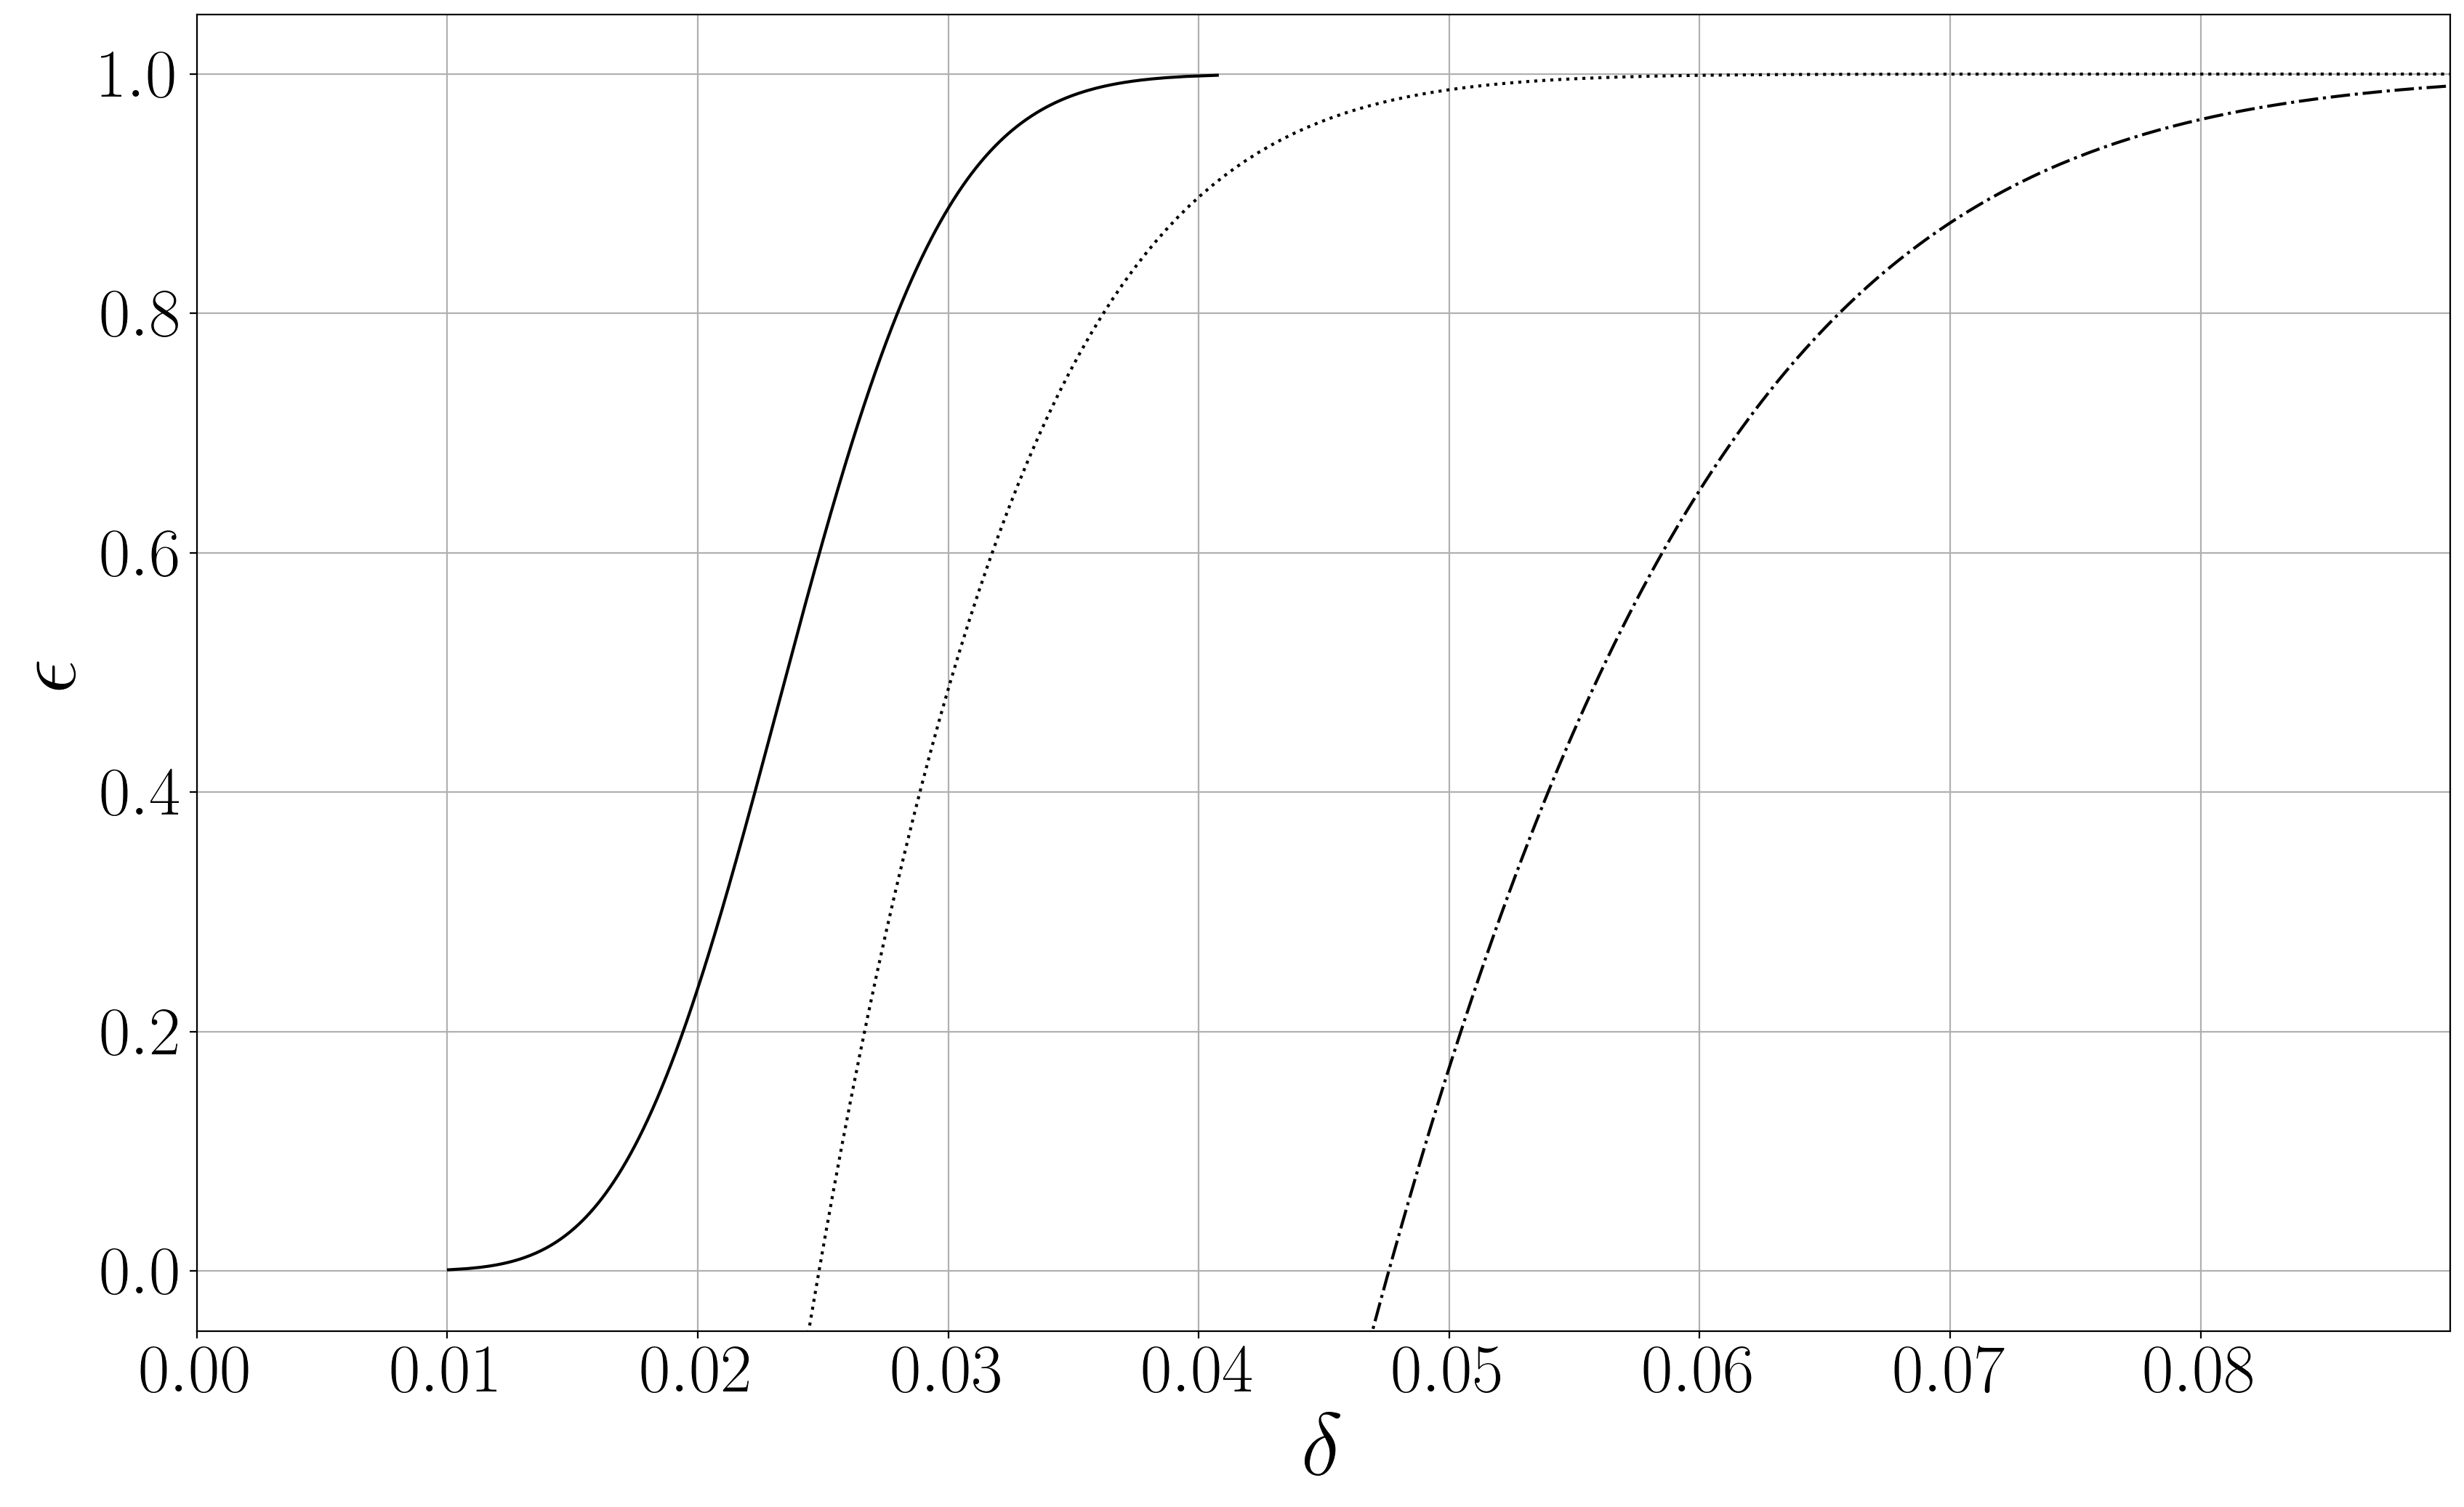

In [53]:
dist_japan, CL_japan = tmg.holder_interval(10000, interval='sugiyama')
dist_renner, CL_renner = tmg.holder_interval(1000, interval='wang')
dist_gamma, CL_gamma = tmg.gamma_interval(1000)

x_max = dist_japan[np.asarray(CL_japan > 0.99).nonzero()[0][0]]

# dist_true = []
# for _ in range(1000):
#     tmg.experiment(n_measurements, POVM)
#     channel_hat = tmg.point_estimate('lifp')
#     dist_true.append(qp.hs_dst(channel_hat.choi, channel.choi))
# dist_true = sorted(dist_true)
# CL_true = np.linspace(0, 1, 1000)

plt.figure(figsize=(20, 12), dpi=200)
plt.xlabel('$\\delta$')
plt.ylabel('$\\epsilon$')
plt.grid()
plt.ylim((-0.05, 1.05))
plt.xlim(right=x_max)
# plt.plot(dist_true, CL_true, 'k', label='True', linestyle='--')
plt.plot(dist_gamma, CL_gamma, 'k', label='Our method', linestyle='-')
plt.plot(dist_japan, CL_japan, 'k', label='Sugiyama (2013)', linestyle='-.')
plt.plot(dist_renner, CL_renner, 'k', label='Wang (2019)', linestyle=':')
full_path = '/home/esthete/Dropbox/RQC/Tomography/gamma_imgs/paper_imgs/teleportation.png'
plt.savefig(full_path)